In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

%matplotlib inline

# Reading in Data

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined)

6484

In [3]:
joined.columns

Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
       'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
       'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
       'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
       'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
       'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
       'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
       'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x',
       'CommonName_y', 'Class', 'CoarseClass', 'IsBinary', 'Unnamed: 0_y',
       'WISE_Designation_x', 'N_obs', 'W1chi2', 'W1chi2red', 'W1_MAD',
       'W1_EWM', 'W2chi2', 'W2chi2red', 'W2_MAD', 'W2_EWM', 'W1-W2chi2',
       'W1-W2chi2red', 'W1-W2_MAD', 'W1-W2_EWM', 'Unnamed: 0',
       'WISE_Designation_y', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
       'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt', 

# Classification algorithms are great at drawing horizontal/vertical lines in feature-space, so we're going to want to make things as easy as possible here, and use PCA to pull out features of maximum variance. This will also let us construct colors that span pretty large wavelength baselines through linear combinations.

In [4]:
#Let's throw out classes that we don't care about/aren't specific enough, plus binaries
training_indices = np.array([c not in np.array(['Misc. Variable','OBA','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

#Our features will be color and G/W1 magnitude.
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1']]
y = training_data['Class']

len(y)

2948

In [34]:
from sklearn.metrics import mean_squared_error
def my_scorer(estimator, X, y=None):
    try:
        X = X.values
        X_reduced = estimator.transform(X)
        X_preimage = estimator.inverse_transform(X_reduced)
        return -1 * mean_squared_error(X, X_preimage)
    except:
        return -np.inf

loggamma_def = np.log10(1.0/len(X.columns))

param_grid = [{"kernel": ["rbf"]}, 
              {"kernel": ["sigmoid"], "coef0": np.linspace(0,5,11)},
              {"kernel": ["poly"], "coef0": np.linspace(0,5,11), "degree": [2,3,4]}]

kpca=KernelPCA(n_components=9, fit_inverse_transform=True, gamma=0.05, n_jobs=-1) 
grid = GridSearchCV(kpca, param_grid, cv=3, scoring=my_scorer)
grid.fit(X)

kpca = grid.best_estimator_
kern = kpca.kernel
gam = kpca.gamma
c0 = kpca.coef0
deg = kpca.degree
print(f'KernelPCA with {kern} kernel')
if kern in ['poly','sigmoid']:
    print(f'coef0 = {c0}')
if kern == 'poly':
    print(f'degree = {deg}')

/Users/carina/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KernelPCA with poly kernel
coef0 = 5.0
degree = 3


In [35]:
X_r = pd.DataFrame(data=kpca.fit_transform(X),columns=[f'C_{i}' for i in range(kpca.n_components)])

In [36]:
X_r

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8
0,-17.366111,-4.636066,2.675294,1.023494,-0.003769,-1.406514,-1.019733,0.002271,-0.882627
1,-18.698214,-5.290157,1.793734,0.668162,0.339390,-2.016091,-1.231599,0.210665,-0.578463
2,-19.541386,-4.879721,1.546540,0.778442,0.363128,-2.568468,-1.238928,0.443714,-0.685057
3,-17.986617,-4.826753,2.075737,0.821964,0.172704,-1.688011,-1.063407,0.121498,-0.691543
4,-18.658740,-3.874783,1.049600,0.352722,0.356343,-2.190932,-0.759456,0.512051,-0.489232
...,...,...,...,...,...,...,...,...,...
2943,7.582379,-4.977833,-4.152600,-0.678592,-1.418020,2.136261,-1.205758,2.169546,0.079865
2944,1.147536,-3.001643,-3.792238,-0.577875,0.321956,2.439715,-0.882536,1.448385,0.526560
2945,4.235616,-8.255695,-4.615321,-0.063396,-1.167107,2.887200,-0.844208,2.619452,-0.104813
2946,1.751283,-5.632459,-5.957359,0.152129,-3.425167,2.314371,-2.190799,1.976649,0.630762


In [37]:
mean_feature = np.mean(X.values, axis=0)
mean_r = kpca.transform([mean_feature])
X_r_test = np.tile(mean_r,(900,1))
for i,col in enumerate(X_r.columns):
    vals_range = np.linspace(np.min(X_r[col]),np.max(X_r[col]),100)
    X_r_test[100*i:100*(i+1),i] = vals_range
    
X_test = pd.DataFrame(data=kpca.inverse_transform(X_r_test),columns=X.columns)

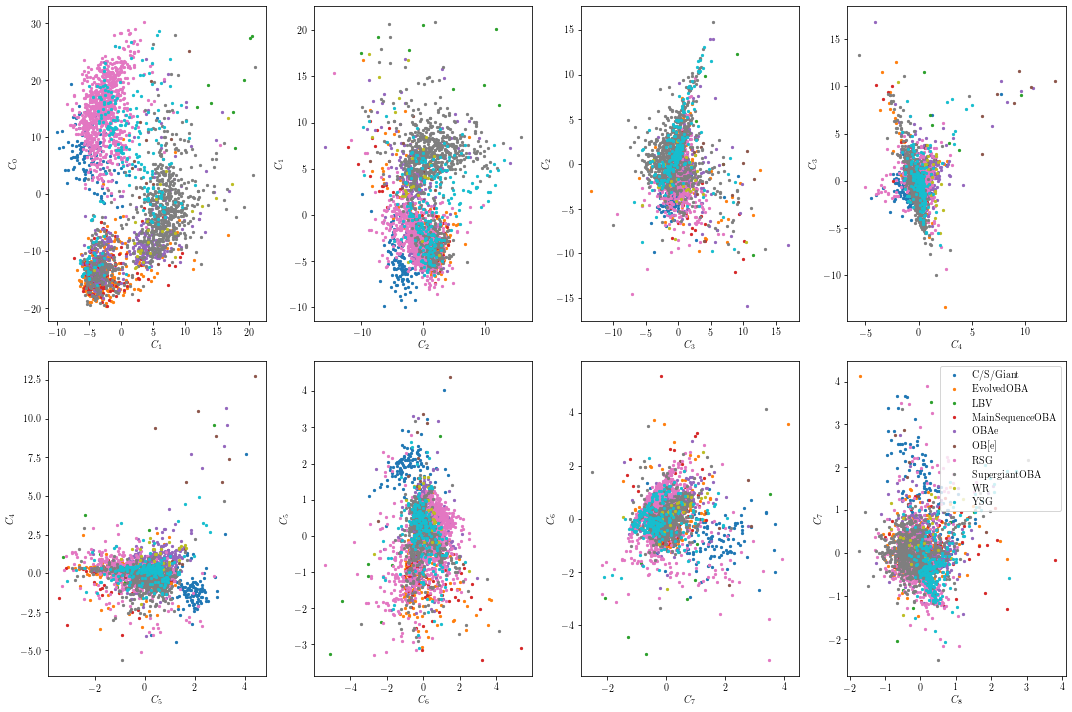

In [38]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
a = ax.flatten()
for i in range(kpca.n_components-1):
    for j,cl in enumerate(np.unique(y)):
        this_class = X_r[y==cl]
        if i == 7:
            lab = cl
        else:
            lab = None
        a[i].scatter(this_class[f'C_{i+1}'],this_class[f'C_{i}'],s=5,label=lab)
    a[i].set(ylabel=f'$C_{i}$',xlabel=f'$C_{i+1}$')
a[7].legend()
plt.tight_layout()

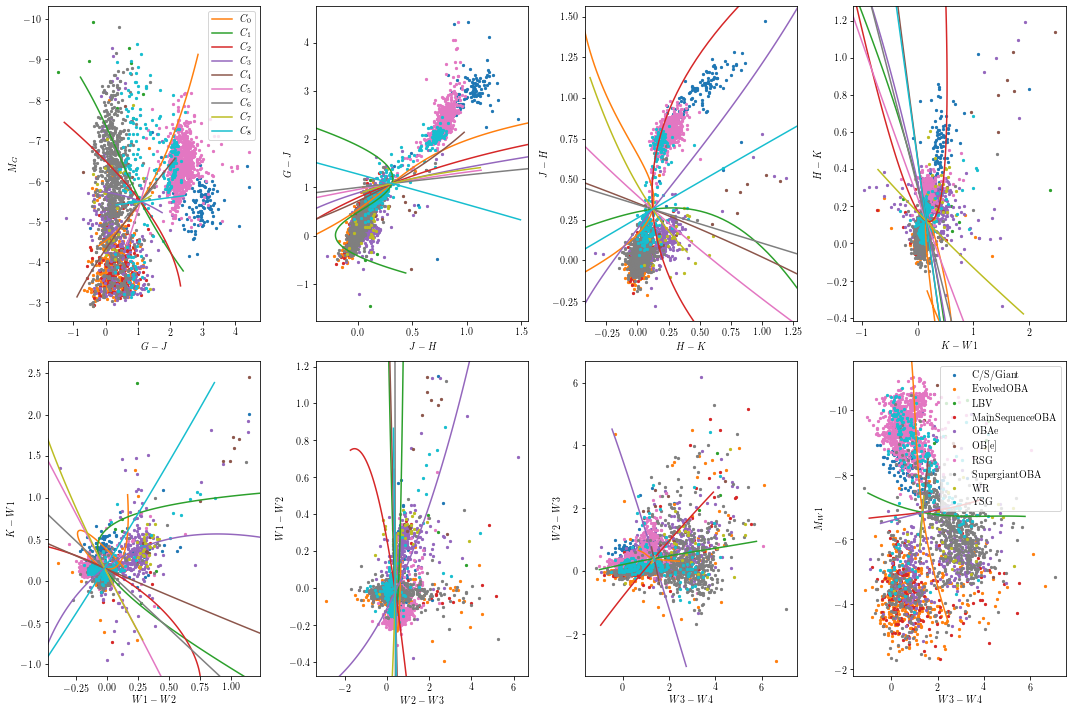

In [39]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
a = ax.flatten()
for i,col in enumerate(X.columns.values[:-1]):
    for j,cl in enumerate(np.unique(y)):
        this_class = X[y==cl]
        if i != 7:
            a[i].scatter(this_class[f'{X.columns.values[i+1]}'],this_class[f'{col}'],s=5)
            a[i].set(ylabel=f'${col}$',xlabel=f'${X.columns.values[i+1]}$')
        else:
            a[i].scatter(this_class[f'{col}'],this_class[f'{X.columns.values[i+1]}'],s=5,label=cl)
            a[i].set(xlabel=f'${col}$',ylabel=f'${X.columns.values[i+1]}$')
        if i in [0,7]:
            a[i].invert_yaxis()
            
xlims = [axis.get_xlim() for axis in a]
ylims = [axis.get_ylim() for axis in a]
        
for i,col in enumerate(X_r.columns):
    X_comp = X_test.iloc[100*i:100*(i+1),:]
    for j,col in enumerate(X.columns.values[:-1]):
        if j == 0:
            a[j].plot(X_comp[f'{X.columns.values[j+1]}'],X_comp[f'{col}'],c=f'C{i+1}',label=f'$C_{i}$')
        elif j == 7:
            a[j].plot(X_comp[f'{col}'],X_comp[f'{X.columns.values[j+1]}'],c=f'C{i+1}')
        else:
            a[j].plot(X_comp[f'{X.columns.values[j+1]}'],X_comp[f'{col}'],c=f'C{i+1}')
a[7].legend()
a[0].legend()

for i in range(len(a)):
    a[i].set_xlim(xlims[i])
    a[i].set_ylim(ylims[i])
    if i in [0,7]:
        a[i].invert_yaxis()

plt.tight_layout()

In [19]:
X_r['Class'] = y
X_r.to_csv('transformed_features.csv',index=False)